In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob

In [3]:
def dictionary_match(y, D, t1_t2_list):
    # get best match
    z = np.dot(D, y)
    i = np.argmax(np.abs(z))
    return t1_t2_list[i,0], t1_t2_list[i,1]

In [5]:
D = np.load("data/dictionary_mrf.npy")

In [6]:
test = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_1.npy")
mrf_dict = scipy.io.loadmat('/mikRAID/jtamir/projects/MRF_direct_contrast_synthesis/data/DictionaryAndSequenceInfo/fp_dictionary.mat')
fp_dict = mrf_dict['fp_dict']
t1_list = mrf_dict['t1_list']
t2_list = mrf_dict['t2_list']
t1_t2_list = np.hstack((t1_list, t2_list))

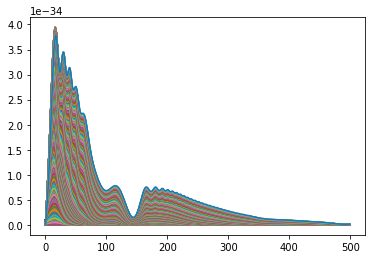

In [7]:
plt.plot(fp_dict[0][0][0])
plt.show()

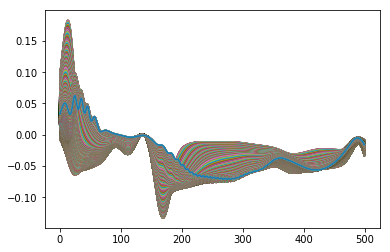

In [34]:
plt.plot(fp_dict[0][0][1])
plt.show()

In [8]:
test = test[0:500] + 1j*test[500:1000]
test = test.reshape(500,-1)

res = np.dot(D, test)
indices = np.argmax(np.abs(res), axis=0) # find max correlation

T1_mapping = t1_list[indices].reshape(320,320) # map to t1
T2_mapping = t2_list[indices].reshape(320,320) # map to t2

mask = np.load()

TypeError: load() missing 1 required positional argument: 'file'

In [180]:
# masking
# for filename in glob.glob("../../MRF/data/MRF_test/*.npy"):
#     print(filename)
#     x = np.load(filename).T
#     x = x[0:500] + 1j*x[500:1000]
#     x = (np.abs(np.mean(x, 0)))
#     x[x<0.1] = 0
#     x[x>=0.1] = 1
#     x = x.astype(np.bool)
#     np.save("../../MRF/data/MRF_test_masks/" + filename.split("/")[-1], x)

../../MRF/data/MRF_test/MRF_norm_volunteer12_1.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_10.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_2.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_4.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_3.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_5.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_9.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_6.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_7.npy
../../MRF/data/MRF_test/MRF_norm_volunteer12_8.npy


In [176]:
# mrf_recon = 1/mrf_recon
mrf_recon[x == 0] = 0 

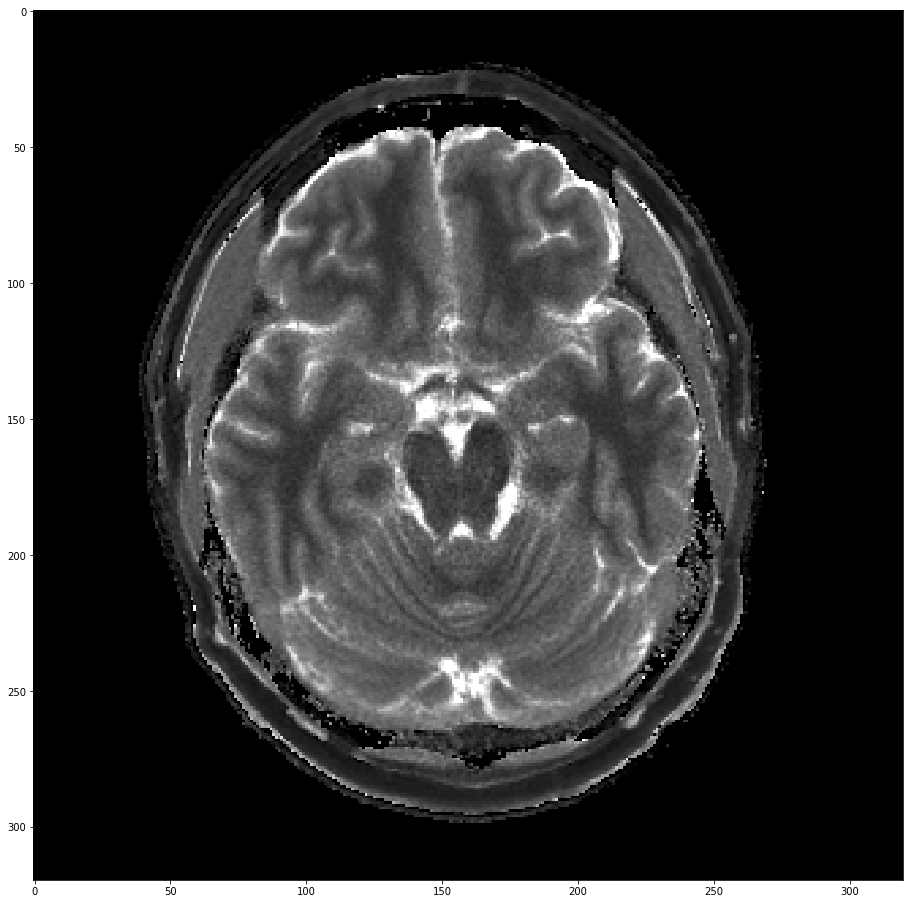

In [177]:
plt.figure(figsize=(16,16))
plt.imshow(np.abs(mrf_recon), cmap='gray')
plt.show()

 # T1 Weighted Simulation